In [1]:
import optuna
import joblib
import optuna.visualization as vis
import time

from Generators.GA.TestGeneticAlgorithm import GeneticAlgorithm
from Generators.Operators.CrossoverMethod import CrossoverMethod
from Generators.Operators.MutationRate import MutationRate
from Generators.Operators.SelectionMethod import SelectionMethod

c:\Users\rsore\anaconda3\envs\TX_prediction\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ------------------------ pareto_front optimization ------------------------


# ----- Fixed experiment settings -----
base_kwargs = {
    "cnn_model_path": 'Models/CNN_6_1_2.keras',
    "masked_sequence": "AATACTAGAGGTCTTCCGACNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGTGTGGGCGGGAAGACAACTAGGGG",
    "target_expression": 1,
    "generations": 100,
    "population_size": 100,
    "track_history": False,
    "track_convergence": False,
    "elitism_rate": 0,
    "survival_rate": 0.5,
    "seed": 42
}

NUM_LINEAGES = 5

# ----- Objective Function -----
def objective(trial):
    # Mutation
    mutation_method = trial.suggest_categorical("mutation_method", MutationRate.get_all_methods())
    mutation_prob = trial.suggest_float("mutation_prob", 0, 1.0)
    mutation_by_deletion_rate = trial.suggest_float("mutation_by_deletion_rate", 0, 1.0)

    mutation_rate = None
    mutation_rate_start = None
    mutation_rate_end = None
    mutation_rate_degree = None

    if mutation_method == "mutConstant":
        mutation_rate = trial.suggest_float("mutation_rate", 0, 1.0)
    elif mutation_method in ["mutLinear", "mutEntropy"]:
        mutation_rate_start = trial.suggest_float("mutation_rate_start", 0, 1.0)
        mutation_rate_end = trial.suggest_float("mutation_rate_end", 0, 1.0)
    elif mutation_method == "mutExponential":
        mutation_rate_start = trial.suggest_float("mutation_rate_start", 0, 1.0)
        mutation_rate_end = trial.suggest_float("mutation_rate_end", 0, 1.0)
        mutation_rate_degree = trial.suggest_int("mutation_rate_degree", 1, 4)

    # Crossover
    crossover_method = trial.suggest_categorical("crossover_method", CrossoverMethod.get_all_methods())
    crossover_rate = trial.suggest_float("crossover_rate", 0, 1.0)
    crossover_points = None
    if crossover_method in ["cxKPoint", "cxTwoPoint"]:
        crossover_points = trial.suggest_int("crossover_points", 1, 4)

    # Selection
    selection_method = trial.suggest_categorical("selection_method", SelectionMethod.get_all_methods())
    boltzmann_temperature = None
    tournsize = None
    if selection_method == "selBoltzmann":
        boltzmann_temperature = trial.suggest_float("boltzmann_temperature", 0, 1.0)
    elif selection_method in ["selTournament", "selTournamentWithoutReplacement"]:
        tournsize = trial.suggest_int("tournsize", 1, 10)

    # Always-used parameters
    elitism_rate = trial.suggest_float("elitism_rate", 0, 1)
    survival_rate = trial.suggest_float("survival_rate", 0, 1)

    # --- GA kwargs ---
    kwargs = base_kwargs.copy()
    kwargs.update({
        "mutation_method": mutation_method,
        "mutation_prob": mutation_prob,
        "mutation_by_deletion_rate": mutation_by_deletion_rate,
        "crossover_method": crossover_method,
        "crossover_rate": crossover_rate,
        "selection_method": selection_method,
        "elitism_rate": elitism_rate,
        "survival_rate": survival_rate
    })

    if mutation_rate is not None:
        kwargs["mutation_rate"] = mutation_rate
    if mutation_rate_start is not None:
        kwargs["mutation_rate_start"] = mutation_rate_start
    if mutation_rate_end is not None:
        kwargs["mutation_rate_end"] = mutation_rate_end
    if mutation_rate_degree is not None:
        kwargs["mutation_rate_degree"] = mutation_rate_degree

    if crossover_points is not None:
        kwargs["crossover_points"] = crossover_points

    if boltzmann_temperature is not None:
        kwargs["boltzmann_temperature"] = boltzmann_temperature
    if tournsize is not None:
        kwargs["tournsize"] = tournsize

    # --- Run GA ---
    try:
        ga = GeneticAlgorithm(**kwargs)
        start_time = time.time()
        ga.run(lineages=NUM_LINEAGES)
        end_time = time.time()
        max_fitness = max(ga.best_fitnesses)
        average_fitness = sum(ga.best_fitnesses) / len(ga.best_fitnesses)
        runtime = end_time - start_time
        return max_fitness, average_fitness, runtime
    except Exception as e:
        print(f"Trial failed: {e}")
        return 0.0, 0.0, float("inf")

# ----- Run Optimization -----
def run_optimization(n_trials=50):
    study = optuna.create_study(directions=["maximize", "maximize", "minimize"], sampler=optuna.samplers.TPESampler())
    study.optimize(objective, n_trials=n_trials)

    return study


In [3]:
study = run_optimization(n_trials=200)

[I 2025-05-11 20:32:10,699] A new study created in memory with name: no-name-878b1a5f-35e4-4511-b570-54c0e2298c49
[I 2025-05-11 20:32:37,309] Trial 0 finished with values: [0.7278436422348022, 0.7173630833625794, 26.43183946609497] and parameters: {'mutation_method': 'mutEntropy', 'mutation_prob': 0.7502196830487934, 'mutation_by_deletion_rate': 0.41852106822436086, 'mutation_rate_start': 0.9311477975368458, 'mutation_rate_end': 0.9217377046761324, 'crossover_method': 'cxOnePoint', 'crossover_rate': 0.6144312698049044, 'selection_method': 'selBest', 'elitism_rate': 0.5226421991002623, 'survival_rate': 0.987319369731687}.
[I 2025-05-11 20:33:09,606] Trial 1 finished with values: [0.7588212490081787, 0.7058565378189087, 32.15183663368225] and parameters: {'mutation_method': 'mutConstant', 'mutation_prob': 0.8404065891923009, 'mutation_by_deletion_rate': 0.6406694443085853, 'mutation_rate': 0.05360811217034689, 'crossover_method': 'cxUniform', 'crossover_rate': 0.3134574460390277, 'select

In [4]:
joblib.dump(study, "Data/Optimizer Hyperparameters/GA_hp_pareto_with_del_200.pkl")

['Data/Optimizer Hyperparameters/GA_hp_pareto_with_del_200.pkl']

In [13]:
study = joblib.load("Data/Optimizer Hyperparameters/GA_hp_pareto_with_del_200.pkl")

In [14]:
vis.plot_param_importances(study).show()

In [7]:
fig = vis.plot_pareto_front(
    study,
    targets=lambda t: (t.values[0], t.values[1]),
    target_names=["Max Fitness", "Mean Fitness"],
).show()

fig = vis.plot_pareto_front(
    study,
    targets=lambda t: (t.values[0], t.values[2]),
    target_names=["Min Fitness", "Runtime"],
).show()

fig = vis.plot_pareto_front(
    study,
    targets=lambda t: (t.values[1], t.values[2]),
    target_names=["Mean Fitness", "Runtime"],
).show()

In [15]:
print(study.trials[51].values)
for k, v in study.trials[51].params.items():
    print(f"  {k}: {v}")

[0.923918604850769, 0.8450579524040223, 44.26289939880371]
  mutation_method: mutLinear
  mutation_prob: 0.9724134473200928
  mutation_by_deletion_rate: 0.1865662871079647
  mutation_rate_start: 0.1776760399937272
  mutation_rate_end: 0.021495672838030666
  crossover_method: cxKPoint
  crossover_rate: 0.01884623749434998
  crossover_points: 4
  selection_method: selTournament
  tournsize: 9
  elitism_rate: 0.08693222344646767
  survival_rate: 0.8103851555137289


In [9]:
import optuna

def is_dominated(trial_values, other_values):
    return all(tv <= ov for tv, ov in zip(trial_values, other_values)) and any(tv < ov for tv, ov in zip(trial_values, other_values))

def get_pareto_front_trials(study):
    completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    pareto_trials = []

    for trial in completed_trials:
        dominated = False
        for other in completed_trials:
            if trial.number != other.number and is_dominated(trial.values, other.values):
                dominated = True
                break
        if not dominated:
            pareto_trials.append(trial)

    return pareto_trials

pareto_trials = get_pareto_front_trials(study)

for t in pareto_trials:
    print(f"Trial {t.number}:")
    print(f"  Values: {t.values}")
    print(f"  Params: {t.params}")


Trial 12:
  Values: [0.8956600427627563, 0.8491518497467041, 41.03565549850464]
  Params: {'mutation_method': 'mutLinear', 'mutation_prob': 0.9819365445375368, 'mutation_by_deletion_rate': 0.19540522987303344, 'mutation_rate_start': 0.18414394546821544, 'mutation_rate_end': 0.03751556972142428, 'crossover_method': 'cxKPoint', 'crossover_rate': 0.0018307391073909421, 'crossover_points': 4, 'selection_method': 'selTournament', 'tournsize': 9, 'elitism_rate': 0.05257648286443003, 'survival_rate': 0.7762406950234005}
Trial 51:
  Values: [0.923918604850769, 0.8450579524040223, 44.26289939880371]
  Params: {'mutation_method': 'mutLinear', 'mutation_prob': 0.9724134473200928, 'mutation_by_deletion_rate': 0.1865662871079647, 'mutation_rate_start': 0.1776760399937272, 'mutation_rate_end': 0.021495672838030666, 'crossover_method': 'cxKPoint', 'crossover_rate': 0.01884623749434998, 'crossover_points': 4, 'selection_method': 'selTournament', 'tournsize': 9, 'elitism_rate': 0.08693222344646767, 'su

Cluster 1 | Trial 12 | Values [0.8956600427627563, 0.8491518497467041, 41.03565549850464] | Params {'mutation_method': 'mutLinear', 'mutation_prob': 0.9819365445375368, 'mutation_by_deletion_rate': 0.19540522987303344, 'mutation_rate_start': 0.18414394546821544, 'mutation_rate_end': 0.03751556972142428, 'crossover_method': 'cxKPoint', 'crossover_rate': 0.0018307391073909421, 'crossover_points': 4, 'selection_method': 'selTournament', 'tournsize': 9, 'elitism_rate': 0.05257648286443003, 'survival_rate': 0.7762406950234005}
Cluster 0 | Trial 51 | Values [0.923918604850769, 0.8450579524040223, 44.26289939880371] | Params {'mutation_method': 'mutLinear', 'mutation_prob': 0.9724134473200928, 'mutation_by_deletion_rate': 0.1865662871079647, 'mutation_rate_start': 0.1776760399937272, 'mutation_rate_end': 0.021495672838030666, 'crossover_method': 'cxKPoint', 'crossover_rate': 0.01884623749434998, 'crossover_points': 4, 'selection_method': 'selTournament', 'tournsize': 9, 'elitism_rate': 0.0869

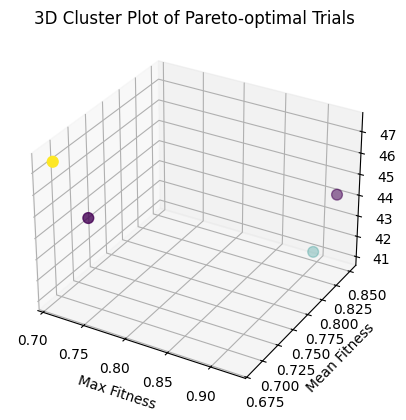

In [10]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

X = pd.DataFrame([t.values for t in pareto_trials])
kmeans = KMeans(n_clusters=3).fit(X)
for i, t in enumerate(pareto_trials):
    print(f"Cluster {kmeans.labels_[i]} | Trial {t.number} | Values {t.values} | Params {t.params}")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[0], X[1], X[2], c=kmeans.labels_, s=60)
ax.set_xlabel("Max Fitness")
ax.set_ylabel("Mean Fitness")
ax.set_zlabel("Runtime")
plt.title("3D Cluster Plot of Pareto-optimal Trials")
plt.show()


In [11]:
vis.plot_optimization_history(
    study, 
    target=lambda t: t.values[0],
    target_name="Max Fitness"
).show()
vis.plot_optimization_history(
    study, 
    target=lambda t: t.values[1],
    target_name="Mean Fitness"
).show()
vis.plot_optimization_history(
    study, 
    target=lambda t: t.values[2],
    target_name="Runtime"
).show()

In [12]:
import gc 
gc.collect()

576